# ROXSI 2022 SSA Nortek Signature 1000
Visualize Sig1000 data QC and statistical parameters from ROXSI 2022 Asilomar Small-Scale Array measurements.

In [1]:
# Imports
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import ipympl
# Interactive plots
%matplotlib widget 


In [3]:
# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103094

# Visualize one date or all dates?
date = '2022-07-01'
# date = 'all'

## Read and plot bathymetry

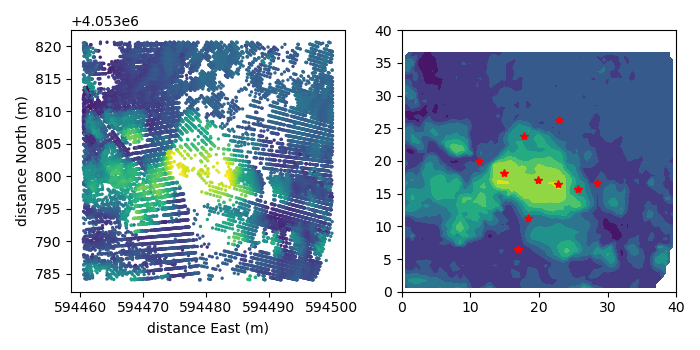

In [16]:
fn_bathy = os.path.join(bathydir, 'Asilomar2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(7,3.5), ncols=2, constrained_layout=True)
axes[0].scatter(dsb.x_pts, dsb.y_pts, c=dsb.z_pts, s=2)
axes[0].set_xlabel('distance East (m)')
axes[0].set_ylabel('distance North (m)')
axes[1].contourf(dsb.X, dsb.Y, dsb.z_grd)
# Mooring locations
axes[1].plot(dsb.C1_est_x.values, dsb.C1_est_y.values, marker='*', color='r')
axes[1].plot(dsb.C2_est_x.values, dsb.C2_est_y.values, marker='*', color='r')
axes[1].plot(dsb.C3_est_x.values, dsb.C3_est_y.values, marker='*', color='r')
axes[1].plot(dsb.C4_est_x.values, dsb.C4_est_y.values, marker='*', color='r')
axes[1].plot(dsb.C5_est_x.values, dsb.C5_est_y.values, marker='*', color='r')
axes[1].plot(dsb.C6_est_x.values, dsb.C6_est_y.values, marker='*', color='r')
axes[1].plot(dsb.L1_est_x.values, dsb.L1_est_y.values, marker='*', color='r')
axes[1].plot(dsb.L2_est_x.values, dsb.L2_est_y.values, marker='*', color='r')
axes[1].plot(dsb.L4_est_x.values, dsb.L4_est_y.values, marker='*', color='r')
axes[1].plot(dsb.L5_est_x.values, dsb.L5_est_y.values, marker='*', color='r')

plt.tight_layout()
plt.show()


## Read Level2 data
If visualizing all dates, concatenate daily netcdf files into one xr.Dataset.